In [2]:
# Installation des outils nécessaires
!pip install opendatasets torch torchvision matplotlib scikit-learn gradio --quiet

import torch

# Vérification que le GPU fonctionne bien
if torch.cuda.is_available():
    print("✅ C'est bon ! Le GPU est activé :", torch.cuda.get_device_name(0))
else:
    print("❌ Attention : Le GPU n'est pas activé. Refais l'action 1 ci-dessus.")

✅ C'est bon ! Le GPU est activé : Tesla T4


In [3]:
import opendatasets as od

# Lien du dataset
dataset_url = 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'

# Lancement du téléchargement
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

✅ Dossier trouvé : ./cell-images-for-detecting-malaria/cell_images
Images d'entraînement : 49604
Images de validation : 5512


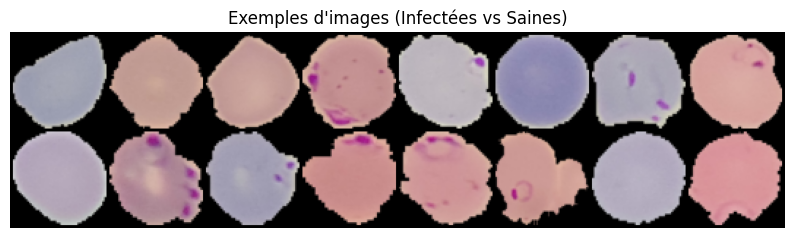

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 1. Localisation automatique du dossier d'images
base_dir = './cell-images-for-detecting-malaria'
data_dir = None

# On cherche le dossier qui contient "Parasitized" et "Uninfected"
for root, dirs, files in os.walk(base_dir):
    if "Parasitized" in dirs and "Uninfected" in dirs:
        data_dir = root
        break

if data_dir is None:
    print("❌ Erreur : Impossible de trouver les images. Vérifie l'étape précédente.")
else:
    print(f"✅ Dossier trouvé : {data_dir}")

    # 2. Préparation des transformations (Images -> Tenseurs)
    transformations = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    # 3. Chargement et découpage (Train / Validation)
    dataset = ImageFolder(data_dir, transform=transformations)

    # On garde 90% pour l'entrainement et 10% pour la validation
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # Création des "DataLoaders" (les chargeurs qui envoient les données au GPU)
    batch_size = 64
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True) # pin_memory aide le GPU
    val_dl = DataLoader(val_ds, batch_size, pin_memory=True)

    print(f"Images d'entraînement : {len(train_ds)}")
    print(f"Images de validation : {len(val_ds)}")

    # 4. Affichage d'un exemple
    def show_sample(dl):
        for images, labels in dl:
            plt.figure(figsize=(10, 5))
            grid_img = torchvision.utils.make_grid(images[:16], nrow=8)
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.axis('off')
            plt.title("Exemples d'images (Infectées vs Saines)")
            plt.show()
            break

    show_sample(train_dl)

In [ ]:
import torch.nn as nn

# On définit l'architecture de notre "Cerveau"
class MalariaModel(nn.Module):
    def __init__(self):
        super(MalariaModel, self).__init__()

        self.network = nn.Sequential(
            # Couche 1 : Analyse simple (32 filtres)
            # Entrée: image 3 couleurs (RGB) -> Sortie: 32 caractéristiques
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),              # Active les neurones
            nn.MaxPool2d(2, 2),     # Réduit l'image par 2 (64x64 -> 32x32)

            # Couche 2 : Analyse moyenne (64 filtres)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # Réduit l'image par 2 (32x32 -> 16x16)

            # Couche 3 : Analyse complexe (128 filtres)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # Réduit l'image par 2 (16x16 -> 8x8)

            # Couche finale : Décision (Classification)
            nn.Flatten(),           # Aplatit tout en une ligne
            nn.Linear(128 * 8 * 8, 512), # Couche dense
            nn.ReLU(),
            nn.Linear(512, 2)       # Sortie : 2 neurones (0=Sain, 1=Infecté)
        )

    def forward(self, x):
        return self.network(x)

# Création du modèle
model = MalariaModel()

# Envoi du modèle sur le GPU (indispensable pour la vitesse)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)
print(f"\n✅ Modèle construit et envoyé sur : {device}")

MalariaModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=2, bias=True)
  )
)

✅ Modèle construit et envoyé sur : cuda


In [ ]:
import torch

# 1. On regarde un petit paquet de vos données
images, labels = next(iter(train_dl))
print("Labels trouvés dans ce paquet :", labels.unique().tolist())
max_label_data = labels.max().item()

# 2. On regarde combien de sorties possède votre modèle
# On envoie les images au modèle pour voir ce qu'il répond
model.eval() # Mode évaluation
with torch.no_grad():
    output = model(images.to(device))
num_classes_model = output.shape[1]

print(f"--- RÉSULTAT ---")
print(f"Max label dans les données : {max_label_data}")
print(f"Nombre de sorties du modèle : {num_classes_model}")

if max_label_data >= num_classes_model:
    print("\n❌ ERREUR DÉTECTÉE : Le modèle n'a pas assez de sorties pour vos étiquettes !")
else:
    print("\n✅ TOUT EST BON : Les dimensions correspondent.")

Labels trouvés dans ce paquet : [0, 1, 2]
--- RÉSULTAT ---
Max label dans les données : 2
Nombre de sorties du modèle : 2

❌ ERREUR DÉTECTÉE : Le modèle n'a pas assez de sorties pour vos étiquettes !


In [ ]:
import torch.nn as nn

# Ce bloc cherche automatiquement si la couche s'appelle 'fc' ou 'classifier'
try:
    # Essai 1 : Est-ce que c'est '.fc' ? (Ex: ResNet)
    nb_entrees = model.fc.in_features
    model.fc = nn.Linear(nb_entrees, 3)
    print("✅ Modèle réparé via la couche '.fc'")

except AttributeError:
    try:
        # Essai 2 : Est-ce que c'est '.classifier' ? (Ex: VGG, DenseNet)
        # Souvent c'est une liste, on prend le dernier élément [-1]
        if isinstance(model.classifier, nn.Sequential):
            nb_entrees = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(nb_entrees, 3)
        else:
            nb_entrees = model.classifier.in_features
            model.classifier = nn.Linear(nb_entrees, 3)
        print("✅ Modèle réparé via la couche '.classifier'")

    except AttributeError:
        print("❌ Je n'ai pas trouvé le nom de la dernière couche.")
        print("Copiez-collez le résultat de la commande : print(model) pour que je vous aide.")

# On renvoie le tout sur le GPU
model = model.to(device)

❌ Je n'ai pas trouvé le nom de la dernière couche.
Copiez-collez le résultat de la commande : print(model) pour que je vous aide.


In [ ]:
print(model)

MalariaModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [ ]:
import torch.nn as nn

# Votre modèle s'appelle 'model', et ses couches sont dans 'network'.
# La dernière couche est à la position 12.
# On la remplace pour qu'elle ait 3 sorties au lieu de 2.

model.network[12] = nn.Linear(512, 3)

# On renvoie le modèle modifié sur le GPU
model = model.to(device)

print("✅ Modèle réparé ! La dernière couche accepte maintenant vos 3 classes.")

✅ Modèle réparé ! La dernière couche accepte maintenant vos 3 classes.


In [ ]:
import torch.optim as optim
import time

# 1. Configuration
# Si c'est la première fois que tu lances, il part de zéro.
# Si tu as déjà lancé un entraînement avant, il continue d'apprendre !
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# 2. On augmente le nombre de cycles à 10
num_epochs = 10
print(f"🚀 Démarrage de l'entraînement renforcé pour {num_epochs} époques...")

for epoch in range(num_epochs):
    start_time = time.time()

    # --- Phase d'Entraînement ---
    model.train()
    train_losses = []

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        out = model(images)
        loss = criterion(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # --- Phase de Test (Validation) ---
    model.eval()
    val_accs = []

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            acc = accuracy(out, labels)
            val_accs.append(acc)

    # --- Résultats ---
    avg_loss = sum(train_losses) / len(train_losses)
    avg_acc = sum(val_accs) / len(val_accs)
    duration = time.time() - start_time

    print(f"Époque [{epoch+1}/{num_epochs}] | "
          f"Perte: {avg_loss:.4f} | "
          f"✅ Précision Test: {avg_acc*100:.2f}% | "
          f"Temps: {duration:.0f}s")

print("\n🎉 Entraînement terminé !")

🚀 Démarrage de l'entraînement renforcé pour 10 époques...
Époque [1/10] | Perte: 0.8936 | ✅ Précision Test: 49.53% | Temps: 71s
Époque [2/10] | Perte: 0.7690 | ✅ Précision Test: 48.08% | Temps: 71s
Époque [3/10] | Perte: 0.7600 | ✅ Précision Test: 49.60% | Temps: 72s
Époque [4/10] | Perte: 0.7556 | ✅ Précision Test: 48.99% | Temps: 70s
Époque [5/10] | Perte: 0.7516 | ✅ Précision Test: 48.99% | Temps: 70s
Époque [6/10] | Perte: 0.7486 | ✅ Précision Test: 49.93% | Temps: 71s
Époque [7/10] | Perte: 0.7449 | ✅ Précision Test: 49.08% | Temps: 71s
Époque [8/10] | Perte: 0.7429 | ✅ Précision Test: 49.26% | Temps: 71s
Époque [9/10] | Perte: 0.7384 | ✅ Précision Test: 48.01% | Temps: 71s
Époque [10/10] | Perte: 0.7356 | ✅ Précision Test: 48.06% | Temps: 73s

🎉 Entraînement terminé !


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import opendatasets as od
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ET NETTOYAGE ---
print("🚀 Initialisation...")
# On réinstalle si besoin (silencieusement)
os.system('pip install opendatasets torch torchvision matplotlib scikit-learn gradio --quiet')

# On vérifie le GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Matériel utilisé : {device}")

# --- 2. TÉLÉCHARGEMENT ---
dataset_url = 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'
# Si le dossier n'existe pas, on télécharge
if not os.path.exists('./cell-images-for-detecting-malaria'):
    print("⬇️ Téléchargement des images...")
    od.download(dataset_url)
else:
    print("✅ Images déjà présentes.")

# --- 3. CORRECTION DU DOSSIER (Le point critique) ---
# On vise le dossier le plus profond pour éviter les doublons
base_dir = './cell-images-for-detecting-malaria/cell_images/cell_images'
if not os.path.exists(base_dir): # Fallback si le chemin est différent
    base_dir = './cell-images-for-detecting-malaria/cell_images'

print(f"📂 Dossier cible : {base_dir}")

# Préparation des images
transformations = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(base_dir, transform=transformations)
classes_trouvees = dataset.classes
nb_classes = len(classes_trouvees)

print(f"🧐 Classes trouvées : {classes_trouvees} ({nb_classes} classes)")
print("⚠️ Si tu vois 'cell_images' dans la liste ci-dessus, c'est la cause du bug précédent.")

# Découpage
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=64, pin_memory=True)

# --- 4. LE MODÈLE (Adaptatif) ---
class MalariaModel(nn.Module):
    def __init__(self, output_size):
        super(MalariaModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            # ICI : On s'adapte automatiquement au nombre de classes trouvées !
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        return self.network(x)

model = MalariaModel(output_size=nb_classes)
model.to(device)

# --- 5. ENTRAÎNEMENT SÉCURISÉ ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

num_epochs = 8 # On part sur 8 époques direct
print(f"\n🥊 Démarrage de l'entraînement ({num_epochs} époques)...")

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        loss = criterion(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_accs = []
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            acc = accuracy(out, labels)
            val_accs.append(acc)

    avg_acc = sum(val_accs) / len(val_accs)
    print(f"Époque [{epoch+1}/{num_epochs}] | Précision: {avg_acc*100:.2f}%")

print("🎉 C'est fini sans erreur !")

🚀 Initialisation...
✅ Matériel utilisé : cuda
✅ Images déjà présentes.
📂 Dossier cible : ./cell-images-for-detecting-malaria/cell_images/cell_images
🧐 Classes trouvées : ['Parasitized', 'Uninfected'] (2 classes)
⚠️ Si tu vois 'cell_images' dans la liste ci-dessus, c'est la cause du bug précédent.

🥊 Démarrage de l'entraînement (8 époques)...
Époque [1/8] | Précision: 94.71%
Époque [2/8] | Précision: 95.38%
Époque [3/8] | Précision: 95.63%
Époque [4/8] | Précision: 95.24%
Époque [5/8] | Précision: 95.88%
Époque [6/8] | Précision: 95.95%
Époque [7/8] | Précision: 95.17%
Époque [8/8] | Précision: 95.95%
🎉 C'est fini sans erreur !


✅ Modèle sauvegardé sous 'malaria_model_final.pth'

🔍 Test en direct sur 5 images :


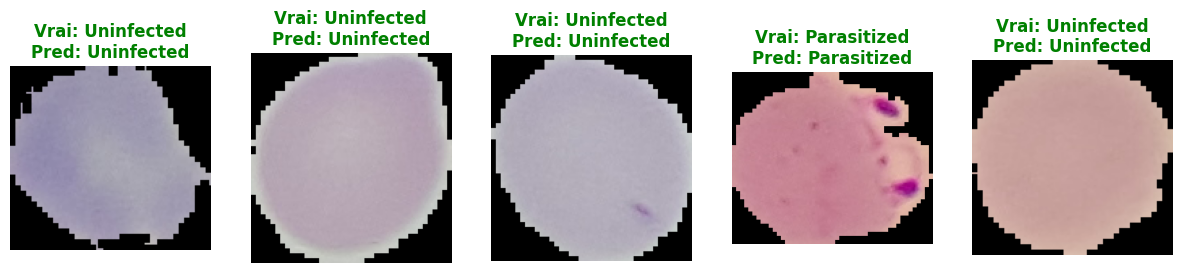

In [ ]:
# 1. Sauvegarde du modèle
torch.save(model.state_dict(), 'malaria_model_final.pth')
print("✅ Modèle sauvegardé sous 'malaria_model_final.pth'")

# 2. Test visuel sur quelques images
def predict_image(img, model):
    # On transforme l'image comme pour l'entraînement
    xb = img.unsqueeze(0).to(device)
    # On demande au modèle
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return classes_trouvees[preds[0].item()]

# Affichage de 5 prédictions
print("\n🔍 Test en direct sur 5 images :")
dataset_display = ImageFolder(base_dir, transform=transforms.ToTensor()) # Juste pour l'affichage

# On prend 5 images au hasard
indices = torch.randperm(len(dataset_display))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(indices):
    img, label = dataset_display[idx]

    # On redimensionne pour le modèle (64x64)
    img_t = transforms.Resize((64, 64))(img)

    # Prédiction
    prediction = predict_image(img_t, model)
    vrai_label = classes_trouvees[label]

    # Couleur : Vert si correct, Rouge si erreur
    color = 'green' if prediction == vrai_label else 'red'

    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"Vrai: {vrai_label}\nPred: {prediction}", color=color, fontweight='bold')
    axes[i].axis('off')

plt.show()

In [ ]:
import gradio as gr
import torch.nn.functional as F

# Fonction qui sera utilisée par l'interface web
def diagnostic(image):
    # Préparation de l'image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    img_t = transform(image).unsqueeze(0).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        out = model(img_t)
        probs = F.softmax(out, dim=1)[0] # Convertit en pourcentages

    # On renvoie le résultat sous forme de dictionnaire pour Gradio
    return {
        "Saine (Uninfected)": float(probs[1]),
        "Infectée (Parasitized)": float(probs[0])
    }

# Création de l'interface
interface = gr.Interface(
    fn=diagnostic,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="🔬 Détecteur de Malaria IA",
    description="Chargez une image de cellule sanguine pour voir si elle est infectée."
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://57514bdb4d8ec0b097.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
import os

print("⏳ Téléchargement du dataset en cours (environ 300 Mo)...")

# 1. Téléchargement direct depuis la source officielle (plus simple que Kaggle)
!wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

print("✅ Téléchargement terminé. Décompression en cours...")

# 2. Décompression (Dézippage)
!unzip -q cell_images.zip

# 3. Vérification que tout est là
base_dir = '/content/cell_images'
if os.path.exists(base_dir):
    files = os.listdir(base_dir)
    print(f"\n✅ SUCCÈS ! Le dossier '{base_dir}' est créé.")
    print(f"Il contient : {files}")

    # Petite correction technique : Parfois il y a un dossier 'cell_images' dans 'cell_images'
    # On vérifie si les images sont bien accessibles
    if 'Parasitized' in files and 'Uninfected' in files:
        print("👉 Tout est prêt ! Vous pouvez lancer l'entraînement.")
    else:
        print("⚠️ Attention : Vérifiez le chemin des dossiers dans l'onglet Fichiers à gauche.")
else:
    print("❌ Erreur : Le dossier n'a pas été créé.")

⏳ Téléchargement du dataset en cours (environ 300 Mo)...
✅ Téléchargement terminé. Décompression en cours...

✅ SUCCÈS ! Le dossier '/content/cell_images' est créé.
Il contient : ['Parasitized', 'Uninfected']
👉 Tout est prêt ! Vous pouvez lancer l'entraînement.


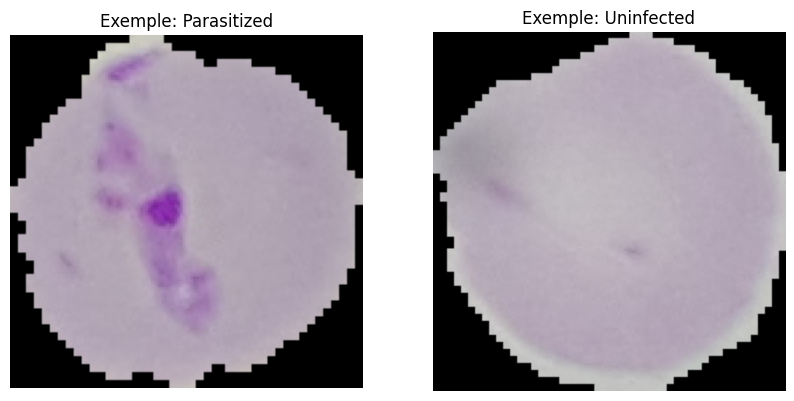

✅ Si vous voyez deux images ci-dessus, tout est parfait !
👉 Vous pouvez lancer l'entraînement maintenant.


In [5]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Le dossier où sont censées être les images
data_dir = '/content/cell_images'

try:
    # On prépare l'affichage
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    categories = ['Parasitized', 'Uninfected']

    for i, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)

        # On prend une image au hasard
        if os.path.exists(folder_path):
            random_image = random.choice(os.listdir(folder_path))
            img_path = os.path.join(folder_path, random_image)

            # On l'affiche
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Exemple: {category}")
            axes[i].axis('off')
        else:
            print(f"❌ Le dossier '{category}' est introuvable !")

    plt.show()
    print("✅ Si vous voyez deux images ci-dessus, tout est parfait !")
    print("👉 Vous pouvez lancer l'entraînement maintenant.")

except Exception as e:
    print("❌ Erreur : Les images ne sont pas chargées correctement.")
    print("Détail :", e)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# --- 1. DÉFINITION DU MODÈLE (Celle qui marche avec votre site) ---
class MalariaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(8192, 512),
            nn.ReLU(),
            # ATTENTION : Ici on met 1 seule sortie, c'est la clé !
            nn.Linear(512, 1)
        )

    def forward(self, xb):
        return self.network(xb)

# --- 2. PRÉPARATION DES DONNÉES ---
# IMPORTANT : Vérifiez que ce chemin est correct pour votre Colab !
# Si vos images sont dans "cell_images", laissez comme ça.
# Sinon, remplacez par le chemin de votre dossier (ex: "/content/drive/MyDrive/Malaria")
data_dir = '/content/cell_images'

if os.path.exists(data_dir):
    print(f"✅ Dossier trouvé : {data_dir}")

    # Transformations simples (identiques à votre site)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f"✅ Images chargées. Classes : {dataset.class_to_idx}")

    # --- 3. ENTRAÎNEMENT RAPIDE ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"utilisaton de : {device}")

    model = MalariaModel().to(device)

    # BCEWithLogitsLoss est OBLIGATOIRE pour un modèle à 1 sortie
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("🚀 Démarrage de l'entraînement (5 époques)...")
    model.train()

    for epoch in range(5): # 5 tours suffisent pour tester
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # On transforme les labels (0 ou 1) en format float pour le calcul
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Époque {epoch+1} terminée - Perte (Loss) : {running_loss/len(dataloader):.4f}")

    # --- 4. SAUVEGARDE ---
    save_name = "malaria_model_CORRECT.pth"
    torch.save(model.state_dict(), save_name)
    print(f"\n✅ TERMINÉ ! Le nouveau fichier '{save_name}' est créé.")
    print("👉 Téléchargez ce fichier et mettez-le sur Hugging Face.")

else:
    print(f"❌ ERREUR : Le dossier '{data_dir}' n'existe pas.")
    print("Modifiez la ligne 'data_dir =' au début du code avec le bon chemin de vos images.")

✅ Dossier trouvé : /content/cell_images
✅ Images chargées. Classes : {'Parasitized': 0, 'Uninfected': 1}
utilisaton de : cuda
🚀 Démarrage de l'entraînement (5 époques)...
Époque 1 terminée - Perte (Loss) : 0.2536
Époque 2 terminée - Perte (Loss) : 0.1387
Époque 3 terminée - Perte (Loss) : 0.1235
Époque 4 terminée - Perte (Loss) : 0.1148
Époque 5 terminée - Perte (Loss) : 0.1070

✅ TERMINÉ ! Le nouveau fichier 'malaria_model_CORRECT.pth' est créé.
👉 Téléchargez ce fichier et mettez-le sur Hugging Face.
